### Задание 1. A/B–тестирование
**1.1 Условие**

    Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. 
В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

**1.3 Вопросы**

Предлагаем Вам ответить на следующие вопросы:

- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?

Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

In [123]:
import pandas as pd
import numpy as np
import requests
from urllib.parse import urlencode
import json



from scipy.stats import norm
from scipy.stats import chi2_contingency
from tqdm.auto import tqdm
from scipy.stats import shapiro



import seaborn as sns
import matplotlib.pyplot as plt

sns.set(
    font_scale=1.2,
    style="darkgrid",
    rc={'figure.figsize': (12, 5)})

plt.style.use('ggplot')

#### Получение данных

Считываем .csv файлы с Яндекс Диска

In [6]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = ['https://disk.yandex.ru/d/58Us0DWOzuWAjg', 'https://disk.yandex.ru/d/3aARY-P9pfaksg',
              'https://disk.yandex.ru/d/prbgU-rZpiXVYg', 'https://disk.yandex.ru/d/84hTmELphW2sqQ']
table_name = ['groups.csv', 'groups_add.csv', 'active_studs.csv', 'checks.csv']


In [19]:
for j, k in zip(public_key, table_name):
    url = base_url + urlencode(dict(public_key=j))    # формирование url
    request_url = requests.get(url)                   # запрос на извлечение данных
    download_url = request_url.json()['href']         # парсинг данных
    download_response = requests.get(download_url)    #запрос готовых данных
    with open(k, 'wb') as f:
        f.write(download_response.content)            #открытие на запись, в двоичном режиме

#### Природа датасетов

Информация о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

In [20]:
groups = pd.read_csv('groups.csv', sep=';')

Пользователи, которые прислали спустя 2 дня после передачи данных

In [26]:
groups_add = pd.read_csv('groups_add.csv', sep=',')

Информация о пользователях, которые зашли на платформу в дни проведения эксперимента

In [29]:
active_studs = pd.read_csv('active_studs.csv', sep=',')

Информация об оплатах пользователей в дни проведения эксперимента

In [33]:
checks = pd.read_csv('checks.csv', sep=';')



**Проверяем дупликаты и NULL**

In [36]:
 df = [groups, groups_add, active_studs, checks]

In [43]:
for i in df:
    print(i.duplicated().sum())
    print('')

0

0

0

0



In [44]:
for i in df:
    print(i.isna().sum())
    print('')

id     0
grp    0
dtype: int64

id     0
grp    0
dtype: int64

student_id    0
dtype: int64

student_id    0
rev           0
dtype: int64



Данные без дупликатов и пропусков

**Проводим соединение таблиц**

In [60]:
users = pd.concat((groups, groups_add)) #все пользователи, с присланными через два дня

In [67]:
users.duplicated().sum()  #дупликатов не обнаружено

0

для отображения активности по действию, добавим колонку с единицей

In [80]:
active_studs['active'] = 1
checks['payment'] = 1

Проводим мердж по всем таблицам

In [78]:
df_full = users.merge(active_studs, how='left',left_on='id', right_on='student_id').fillna(0)

In [81]:
df_full = df_full.merge(checks, how='left',left_on='id', right_on='student_id').fillna(0)

In [87]:
df_full = df_full[['id', 'grp', 'active', 'rev',  'payment']] #убираем лишние колонки

In [88]:
df_full.head()

,id,grp,active,rev,payment
0,1489,B,0.0,0.0,0.0
1,1627,A,1.0,990.0,1.0
2,1768,B,0.0,0.0,0.0
3,1783,B,0.0,0.0,0.0
4,1794,A,0.0,0.0,0.0


#### Метрики A/B–тестирования

Основные метрики для анализа: 
- Конверсия (conversion rate, CR) — отношение числа пользователей, которые выполнили какое-либо целевое действие к общему числу пользователей.
- Средний доход на платящего пользователя (ARPPU). Состоит из того, насколько часто пользователь покупает, и насколько большой средний чек покупки.

Фильруем пользователей, которые зашли на платформу в дни проведения эксперимента

In [97]:
active_users = df_full.query('active == 1')

In [99]:
active_users.head()

,id,grp,active,rev,payment
1,1627,A,1.0,990.0,1.0
10,2085,B,1.0,0.0,0.0
12,2215,B,1.0,0.0,0.0
43,3391,A,1.0,0.0,0.0
45,3401,B,1.0,0.0,0.0


**Расчитаем conversion rate**

In [106]:
#Конверсия в покупку для группы А
round(100* active_users.query('payment == 1 & grp == "A"').id.count()/active_users.query('grp == "A"').id.count(), 2)

5.07

In [105]:
#Конверсия в покупку для группы В
round(100* active_users.query('payment == 1 & grp == "B"').id.count()/active_users.query('grp == "B"').id.count(), 2)

4.62

Построим график активных пользователей не совершивших и совершивших покупку с разделением по группам

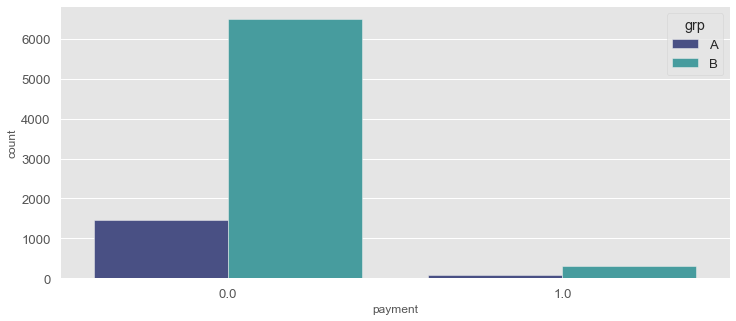

In [98]:
sns.countplot(x="payment", hue="grp", data=active_users, palette='mako');

Конверсии в покупку различаются, но!
Делать вывод по олному расчету и графику – не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста.

Есть две категориальные переменные → используем хи-квадрат

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [111]:
df_cross = pd.crosstab(active_users.grp, active_users.payment)
df_cross

payment,0.0,1.0
grp,,
A,1460,78
B,6489,314


In [112]:
stat, p, dof, expected = chi2_contingency(df_cross)

In [117]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0. Уровень p-value < 0.05. Результаты являются статистички значимыми')
else:
    print('Не отклоняем H0. Уровень p-value > 0.05. Результаты не являются статистички значимыми')

Не отклоняем H0. Уровень p-value > 0.05. Результаты не являются статистички значимыми


**Расчитаем ARPPU**

In [122]:
#добавим расчет медианног значения для оценки чувствительности к выбросам
df_ARPPU = active_users.query('payment == 1').groupby('grp').agg({'rev' : ['mean', 'median']}).round(2)
df_ARPPU

rev        
        mean  median
grp                 
A     933.59   585.0
B    1257.88  1140.0

Таблица показывает различия контрольной и тестовой группы, но требуется проверить статистически

Проверим распределение признака на нормальность с помощью Теста Шапиро-Уилка

In [129]:
alpha = 0.05

st = shapiro(active_users.query('grp ==  "A"').rev)
print('Distribution grp A is {}normal\n'.format({True: 'not ', False: ''}[st[1] < alpha]));

st = shapiro(active_users.query('grp ==  "B"').rev)
print('Distribution grp B is {}normal\n'.format({True: 'not ', False: ''}[st[1] < alpha]));

Distribution grp A is not normal

Distribution grp B is not normal



Дополнительная проверка по графику: Распределение покупок

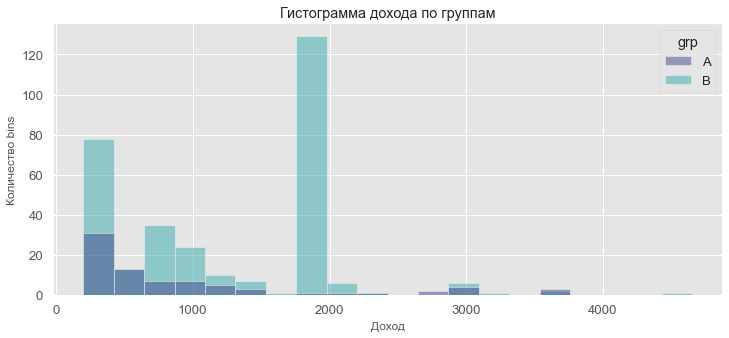

In [132]:
sns.histplot(x=active_users.query('payment == 1').rev, hue=active_users.query('payment == 1').grp, bins=20, palette='mako')
plt.xlabel('Доход')
plt.ylabel('Количество bins')
plt.title("Гистограмма дохода по группам");

На основе данных теста Шапиро-Уилка, подтвержденные графиком Распределения дохода групп, распределения не являются нормальными. T-test в данном случае не применим, а Манн-Уитни проверяет гипотезу о равенстве распределений. Как решение - применим bootstrap

**Bootstrap метод**

 
$H_0$: средние выборок равны $H_1$: средние выборок не равны

In [134]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}







**Bootstrap ARPPU**

  0%|          | 0/1000 [00:00<?, ?it/s]

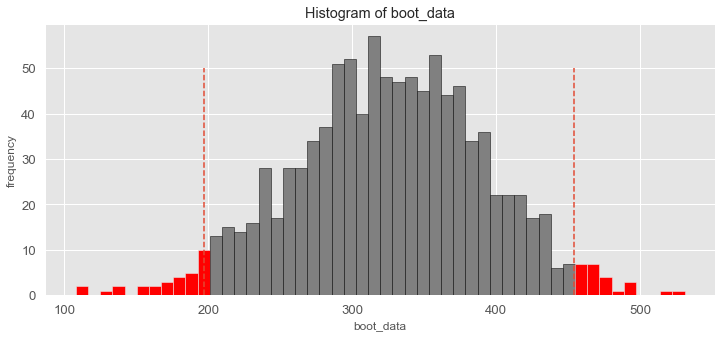

In [145]:
bootstrap_mean = get_bootstrap(active_users.query("payment == 1 and grp == 'B'").rev, 
                                 active_users.query("payment == 1 and grp == 'A'").rev)

In [146]:
bootstrap_mean["p_value"]

7.953538788605067e-07

In [147]:
bootstrap_mean["quants"] # доверительный интервал

,0
0.025,196.939340
0.975,453.681461


In [142]:
prob = 0.95
alpha = 1.0 - prob
if bootstrap_mean["p_value"] <= alpha:
    print('Отклоняем H0. Уровень p-value < 0.05. Результаты являются статистички значимыми')
else:
    print('Не отклоняем H0. Уровень p-value > 0.05. Результаты не являются статистички значимыми')

Отклоняем H0. Уровень p-value < 0.05. Результаты являются статистички значимыми


**Bootstrap MEDIAN**

  0%|          | 0/1000 [00:00<?, ?it/s]

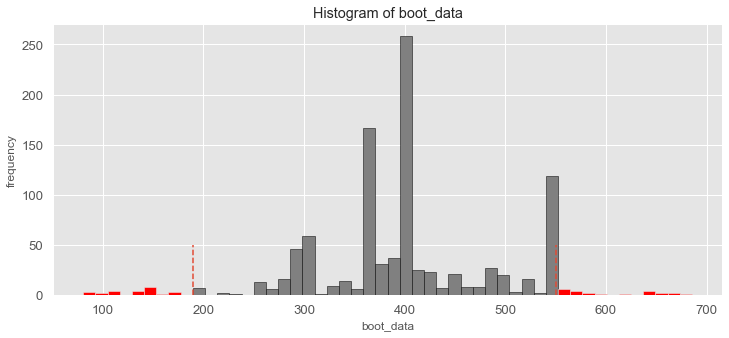

In [149]:
bootstrap_median = get_bootstrap(active_users.query("payment == 1 and grp == 'B'").rev, 
                                 active_users.query("payment == 1 and grp == 'A'").rev, statistic = np.median)

In [150]:
["p_value"]

1.869423545505859e-05

In [151]:
bootstrap_median["quants"] # доверительный интервал

,0
0.025,189.15
0.975,550.00


In [152]:
prob = 0.95
alpha = 1.0 - prob
if bootstrap_median["p_value"] <= alpha:
    print('Отклоняем H0. Уровень p-value < 0.05. Результаты являются статистички значимыми')
else:
    print('Не отклоняем H0. Уровень p-value > 0.05. Результаты не являются статистички значимыми')

Отклоняем H0. Уровень p-value < 0.05. Результаты являются статистички значимыми


**Итоги**

 - Для оценки эффективности новой механики оплаты услуг рассмотрены метрки "Конверсия" - позволет оценить действие покупка. Рассмотрена метрика "ARPPU"   - позволяет оценить средний чек покупки. Дополнительно рассмотрена метрика Медиана чека покупки, для дополнительной проверки выбросов.  
 - Чтобы оценить статистическую значимость конверсии, применялся методи Хи-квадрат, так как переменные номинативные. По результатам теста, не отклоняем H0. Уровень p-value > 0.05. Результаты не являются статистички значимыми.  Новая механика оплаты услуг на сайте не повлияла на конверсию.
 - Чтобы оценить средний чек применялся метод bootstrap. По результатам теста отклоняем H0. Уровень p-value < 0.05. Результаты являются статистички значимыми. Новая механика оплаты услуг на сайте повлияла на средний чек. Средний чек выше в группе B.
 - Чтобы оценить медианный чек применялся метод bootstrap. По результатам теста отклоняем H0. Уровень p-value < 0.05. Результаты являются статистички значимыми. Новая механика оплаты услуг на сайте повлияла на медианный чек. Медианный чек выше в группе B.
 - Так как Медианный чек выше в группе B и Средний чек выше в группе B , то можно применить новую версию для всех пользователей.